In [1]:
ls

ala_6_FF.dcd                         ser_6_FF.dcd*
ala_6_FF.pdb                         ser_6_FF.pdb
ala_6_analysis_FF.ipynb              ser_6_analysis_FF.ipynb
ala_6_analysis_drude-explicit.ipynb  ser_6_analysis_drude-explicit.ipynb
ala_6_analysis_drude-implicit.ipynb  ser_6_analysis_drude-implicit.ipynb
ala_6_analysis_drude-vacuum.ipynb    ser_6_analysis_drude-vacuum.ipynb
ala_6_explicit.dcd*                  ser_6_explicit.dcd*
ala_6_explicit.pdb*                  ser_6_explicit.pdb*
ala_6_implicit.dcd*                  ser_6_implicit.dcd*
ala_6_vacuum.dcd*                    ser_6_vacuum.dcd*
ala_6_vacuum.pdb*                    ser_6_vacuum.pdb*


In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


In [3]:
pdb='ser_6_explicit.pdb'
trajectory='ser_6_explicit.dcd'

In [4]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames


In [5]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 12582

Number of residues: 2490

Number of frames: 2000

Starting frame: 0

Last frame: 2000

sequence:  [SER1, SER2, SER3, SER4, SER5, SER6, SWM41, SWM42, SWM43, SWM44, SWM45, SWM46, SWM47, SWM48, SWM49, SWM410, SWM411, SWM412, SWM413, SWM414, SWM415, SWM416, SWM417, SWM418, SWM419, SWM420, SWM421, SWM422, SWM423, SWM424, SWM425, SWM426, SWM427, SWM428, SWM429, SWM430, SWM431, SWM432, SWM433, SWM434, SWM435, SWM436, SWM437, SWM438, SWM439, SWM440, SWM441, SWM442, SWM443, SWM444, SWM445, SWM446, SWM447, SWM448, SWM449, SWM450, SWM451, SWM452, SWM453, SWM454, SWM455, SWM456, SWM457, SWM458, SWM459, SWM460, SWM461, SWM462, SWM463, SWM464, SWM465, SWM466, SWM467, SWM468, SWM469, SWM470, SWM471, SWM472, SWM473, SWM474, SWM475, SWM476, SWM477, SWM478, SWM479, SWM480, SWM481, SWM482, SWM483, SWM484, SWM485, SWM486, SWM487, SWM488, SWM489, SWM490, SWM491, SWM492, SWM493, SWM494, SWM495, SWM496, SWM497, SWM498, SWM499, SWM4100, SWM4101, SWM4102, SWM4103, SWM

In [6]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([   1,    2,    3, ..., 2488, 2489, 2490])

In [7]:
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'C', 'C', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'C', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'C', ..., 'NA', 'NA', 'NA'],
       ...,
       ['C', 'C', 'C', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'C', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'C', ..., 'NA', 'NA', 'NA']], dtype='<U2')

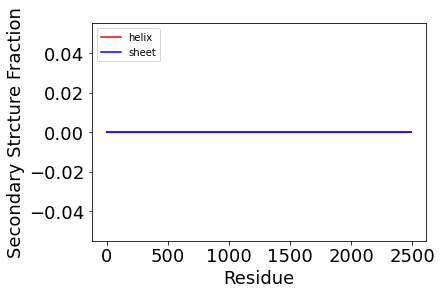

In [8]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)



In [9]:
peptide_CA_pdb='ser_6_vacuum.pdb'
peptide_CA = md.load_pdb(peptide_CA_pdb)
top_SER = peptide_CA.topology
top_SER
residue_SER=[]
for res in top_SER.residues: 
    residue_SER.append(res.resSeq)
resid_SER=np.asarray(residue_SER)
resid_SER

array([1, 2, 3, 4, 5, 6])

In [10]:
trjSER = md.load(trajectory, top=pdb,stride=1)
SER=top.select("backbone")
trjSER.restrict_atoms(SER)
trjSER.center_coordinates()

dssp=md.compute_dssp(trjSER,simplified=True)

In [11]:
trjSER.center_coordinates()
top = trjSER.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

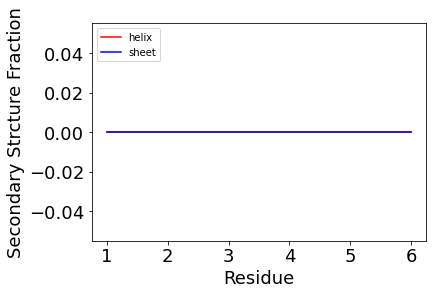

In [12]:
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_SER,Hprop,c='r',label='helix')
plt.plot(resid_SER,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)

In [13]:
trjSER

<mdtraj.Trajectory with 2000 frames, 24 atoms, 6 residues, and unitcells at 0x7fbc68155358>

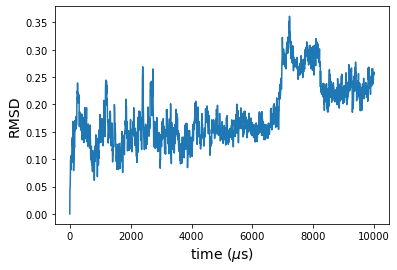

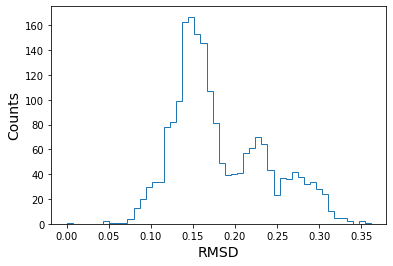

In [22]:
time=np.linspace(0,10000,trjSER.n_frames)
rmsd = md.rmsd(trjSER, trjSER, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

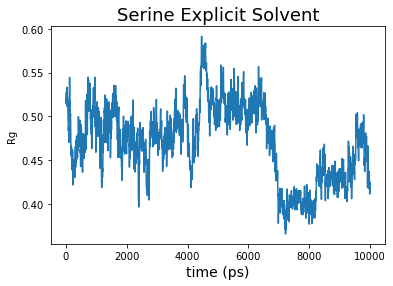

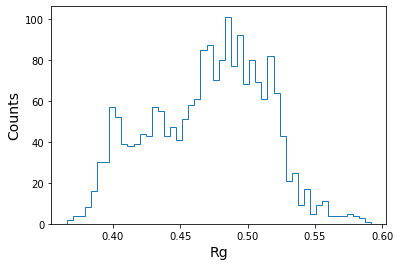

In [24]:
rg=md.compute_rg(trjSER, masses=None)
plt.plot(time,rg)
plt.title('Serine Explicit Solvent',size=18,color='k')
plt.ylabel('Rg');
plt.xlabel('time (ps)',size=14)
plt.show()
plt.clf()


plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

In [16]:
indices_phi, phis = md.compute_phi(trjSER)
indices_psi, psis = md.compute_psi(trjSER)
indices_chi1, chi1s = md.compute_chi1(trjSER)
indices_chi2, chi2s = md.compute_chi2(trjSER)

In [17]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [18]:
def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return


In [19]:
nres=[]
for res in trjSER.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trjSER.topology.residues])
resname=(' %s' % [residue.name for residue in trjSER.topology.residues])
resindex=(' %s' % [residue.index for residue in trjSER.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trjSER.topology.residues])

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trjSER.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trjSER.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 24

Number of residues: 6

Number of frames: 2000

Starting frame: 0

Last frame: 2000

sequence:  [SER1, SER2, SER3, SER4, SER5, SER6]

residue names:  ['SER', 'SER', 'SER', 'SER', 'SER', 'SER']

residue number:  [1, 2, 3, 4, 5, 6]

residue index:  [0, 1, 2, 3, 4, 5]



Serine Explicit - Residue 2


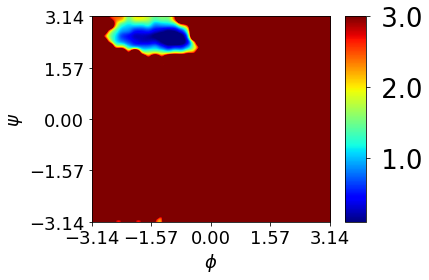

Serine Explicit - Residue 3


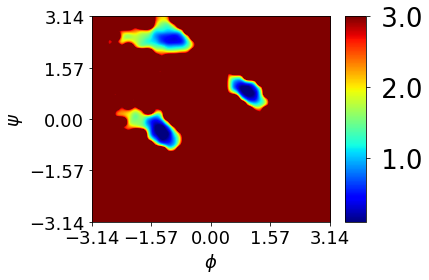

Serine Explicit - Residue 4


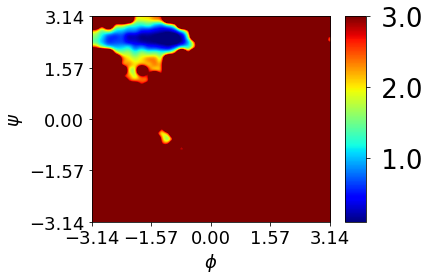

Serine Explicit - Residue 5


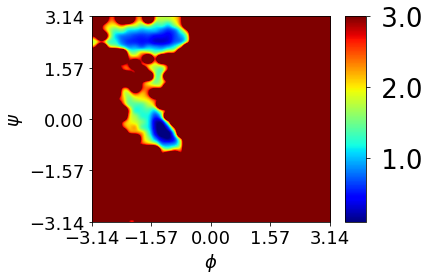

In [20]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],normed=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=3.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

print('Serine Explicit - Residue 2')
plot_phipsi_FES(2)
print('Serine Explicit - Residue 3')
plot_phipsi_FES(3)
print('Serine Explicit - Residue 4')
plot_phipsi_FES(4)
print('Serine Explicit - Residue 5')
plot_phipsi_FES(5)

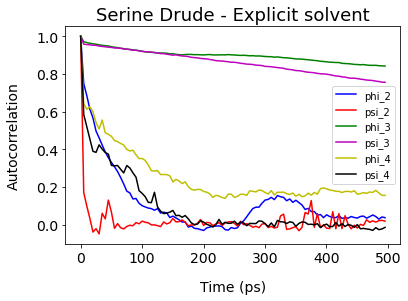

In [25]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,10000,trj.n_frames)


lags=range(100)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][2],lags)
psi2_acf=autocorr1(dihedral_dict['psi'][2],lags)
phi3_acf=autocorr1(dihedral_dict['phi'][3],lags)
psi3_acf=autocorr1(dihedral_dict['psi'][3],lags)
phi4_acf=autocorr1(dihedral_dict['phi'][4],lags)
psi4_acf=autocorr1(dihedral_dict['psi'][4],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_2')
plt.plot(time[lags],psi2_acf,color='r',label='psi_2')
plt.plot(time[lags],phi3_acf,color='g',label='phi_3')
plt.plot(time[lags],psi3_acf,color='m',label='psi_3')
plt.plot(time[lags],phi4_acf,color='y',label='phi_4')
plt.plot(time[lags],psi4_acf,color='k',label='psi_4')

plt.legend()
plt.title("Serine Drude - Explicit solvent",size=18,color='k')
plt.xlabel("Time (ps)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()